In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle


In [ ]:
# Monter Google Drive
drive.mount('/content/drive')

# Chemin du fichier zip
zip_path = '/content/drive/MyDrive/asl_alphabet.zip'

# Décompression
output_path = '/content/asl_alphabet'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)

print("Données décompressées dans :", output_path)


Mounted at /content/drive
Données décompressées dans : /content/asl_alphabet


In [ ]:

# Définir les chemins des répertoires d'entraînement et de test
train_dir = os.path.join(output_path, 'asl_alphabet_train', 'asl_alphabet_train')
test_dir = os.path.join(output_path, 'asl_alphabet_test', 'asl_alphabet_test')

# Vérifier la structure des dossiers d'entraînement
print("Classes d'entraînement :", os.listdir(train_dir))

# Vérifier la structure des dossiers de test
print("Exemples de fichiers de test :", os.listdir(test_dir)[:5])


Classes d'entraînement : ['W', 'K', 'B', 'M', 'R', 'I', 'G', 'P', 'O', 'Z', 'U', 'A', 'nothing', 'V', 'del', 'Y', 'L', 'X', 'space', 'F', 'J', 'C', 'H', 'Q', 'T', 'D', 'E', 'S', 'N']
Exemples de fichiers de test : ['J_test.jpg', 'M_test.jpg', 'H_test.jpg', 'K_test.jpg', 'Y_test.jpg']


In [ ]:
# Création d'un générateur d'images pour l'entraînement avec normalisation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # Réserver 20% des données pour la validation
)

# Générateur pour l'ensemble d'entraînement
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),     # Redimensionnement des images
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

# Générateur pour l'ensemble de validation
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [ ]:
def generator_to_numpy(generator):
    """
    Convertit un générateur d'images en tableaux NumPy.
    """
    steps = np.ceil(generator.samples / generator.batch_size)
    images = []
    labels = []
    for _ in range(int(steps)):
        batch_images, batch_labels = next(generator)
        images.append(batch_images)
        labels.append(batch_labels)
    images = np.vstack(images)
    labels = np.vstack(labels)
    return images, labels

# Convertir les données d'entraînement et de validation
train_images, train_labels = generator_to_numpy(train_generator)
val_images, val_labels = generator_to_numpy(validation_generator)

print("Données d'entraînement :", train_images.shape, train_labels.shape)
print("Données de validation :", val_images.shape, val_labels.shape)


Données d'entraînement : (69600, 64, 64, 3) (69600, 29)
Données de validation : (17400, 64, 64, 3) (17400, 29)


In [ ]:
# **Étape 7 : Chargement et prétraitement des données de test**

# Liste des fichiers de test
test_files = os.listdir(test_dir)

test_images = []
test_labels = []
classes = sorted(os.listdir(train_dir))  # Assurer l'ordre des classes

# Création d'un dictionnaire pour mapper les classes à des indices
class_to_index = {cls_name: idx for idx, cls_name in enumerate(classes)}

for file_name in test_files:
    # Extraire la classe à partir du nom du fichier (ex : A_test.jpg -> A)
    cls = file_name.split('_')[0]
    label = class_to_index.get(cls, -1)  # -1 si la classe n'est pas trouvée
    if label == -1:
        continue  # Ignorer les fichiers avec des classes inconnues

    test_labels.append(label)

    # Charger l'image
    img_path = os.path.join(test_dir, file_name)
    img = cv2.imread(img_path)
    if img is None:
        continue  # Ignorer les fichiers qui ne sont pas des images valides
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
    img = cv2.resize(img, (64, 64))  # Redimensionnement
    img = preprocess_input(img)  # Appliquer la même prétraitement que pour l'entraînement
    test_images.append(img)

# Convertir en tableaux NumPy
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Données de test :", test_images.shape, test_labels.shape)

Données de test : (28, 64, 64, 3) (28,)


In [ ]:
# **Étape 8 : Extraction des caractéristiques avec ResNet50**

# Initialiser le modèle ResNet50 sans la couche de classification finale
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Extraire les caractéristiques pour les ensembles d'entraînement, de validation et de test
train_features = base_model.predict(train_images, batch_size=32, verbose=1)
val_features = base_model.predict(val_images, batch_size=32, verbose=1)
test_features = base_model.predict(test_images, batch_size=32, verbose=1)

print("Caractéristiques d'entraînement :", train_features.shape)
print("Caractéristiques de validation :", val_features.shape)
print("Caractéristiques de test :", test_features.shape)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
544/544 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Caractéristiques d'entraînement : (69600, 2048)
Caractéristiques de validation : (17400, 2048)
Caractéristiques de test : (28, 2048)


In [ ]:
# **Étape 9 : Normalisation des caractéristiques**

# Initialiser le scaler
scaler = StandardScaler()

# Ajuster le scaler sur les données d'entraînement et transformer
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

print("Caractéristiques normalisées.")

Caractéristiques normalisées.


In [ ]:
# **Étape 10 : Réduction de dimensionnalité avec PCA (optionnel)**

# Initialiser PCA avec le nombre de composantes souhaité
pca = PCA(n_components=100, random_state=42)  # Ajustez n_components selon vos besoins

# Ajuster PCA sur les données d'entraînement et transformer
train_features_pca = pca.fit_transform(train_features_scaled)
val_features_pca = pca.transform(val_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

print("Réduction de dimensionnalité avec PCA terminée.")
print("Nouvelles dimensions :", train_features_pca.shape)

Réduction de dimensionnalité avec PCA terminée.
Nouvelles dimensions : (69600, 100)


In [ ]:
# **Étape 11 : Préparer le DataFrame pour ref_data.csv**

# Créer un DataFrame pour les données d'entraînement
df_train = pd.DataFrame(train_features_pca)
df_train['label'] = np.argmax(train_labels, axis=1)  # Convertir les labels one-hot en indices

# Créer un DataFrame pour les données de validation
df_val = pd.DataFrame(val_features_pca)
df_val['label'] = np.argmax(val_labels, axis=1)

# Ajouter les données de validation au DataFrame d'entraînement
df_all = pd.concat([df_train, df_val], ignore_index=True)

# Sauvegarder dans ref_data.csv
ref_data_path = os.path.join(output_path, 'data', 'ref_data.csv')
os.makedirs(os.path.dirname(ref_data_path), exist_ok=True)
df_all.to_csv(ref_data_path, index=False)

print(f"Données transformées sauvegardées dans {ref_data_path}")

Données transformées sauvegardées dans /content/asl_alphabet/data/ref_data.csv


In [ ]:
# **Étape 12 : Sauvegarder les artefacts (scaler et PCA)**

# Chemin du dossier artifacts
artifacts_dir = os.path.join(output_path, 'artifacts')
os.makedirs(artifacts_dir, exist_ok=True)

# Sauvegarder le scaler
scaler_path = os.path.join(artifacts_dir, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

# Sauvegarder le modèle PCA
pca_path = os.path.join(artifacts_dir, 'pca.pkl')
with open(pca_path, 'wb') as f:
    pickle.dump(pca, f)

print(f"Scaler et PCA sauvegardés dans {artifacts_dir}")


Scaler et PCA sauvegardés dans /content/asl_alphabet/artifacts


In [ ]:
# **Étape 13 : Sauvegarder les caractéristiques de test**

# Créer un DataFrame pour les données de test
df_test = pd.DataFrame(test_features_pca)
df_test['label'] = test_labels

# Sauvegarder dans test_data.csv (si nécessaire)
test_data_path = os.path.join(output_path, 'data', 'test_data.csv')
df_test.to_csv(test_data_path, index=False)

print(f"Données de test transformées sauvegardées dans {test_data_path}")


Données de test transformées sauvegardées dans /content/asl_alphabet/data/test_data.csv


          0         1          2         3          4         5          6  \
0 -8.750017  1.270956   9.186795  7.261441  17.463654  7.819411  -3.267434   
1  4.453056 -2.979856 -11.474133 -3.590466   5.692397 -0.345708  14.913405   
2 -8.807736  2.209491   8.874857  4.967010  18.061541  8.130327  -3.129796   
3 -8.944516  4.168016  10.531391  4.514879  20.573200  6.879407  -3.442568   
4 -8.925002  1.387866   8.611262  5.837756  19.629129  7.272402  -4.118851   

          7         8          9  ...        91        92        93        94  \
0 -6.217210  3.794773  -0.842868  ... -1.131872  3.358251  0.615465 -1.358904   
1 -9.886652  9.249639  14.753951  ... -1.284231 -1.142638 -0.261861  1.377515   
2 -6.319090  3.732259  -1.223869  ... -1.138117  3.453526 -0.116136 -1.217226   
3 -6.608138  4.574527   0.154656  ... -2.245056  2.924508  0.513903 -1.017429   
4 -5.660655  3.782082   0.226752  ... -1.965973  2.926963 -0.187243 -1.161200   

         95        96        97        98   

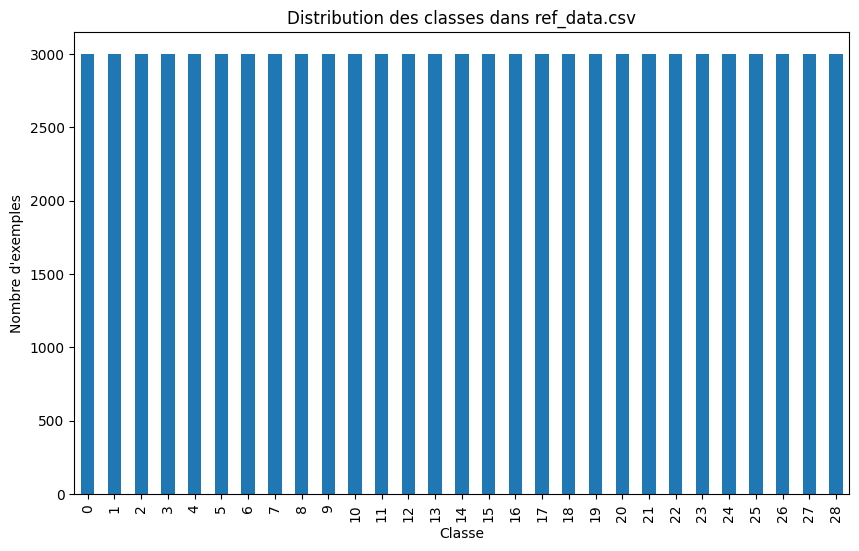

In [ ]:
# **Étape 14 : Visualisation des données (optionnel)**

# Afficher quelques exemples de caractéristiques
print(df_all.head())

# Afficher la distribution des classes
plt.figure(figsize=(10,6))
df_all['label'].value_counts().plot(kind='bar')
plt.title('Distribution des classes dans ref_data.csv')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'exemples')
plt.show()

In [ ]:
# **Étape 15 : Organisation des fichiers sauvegardés dans Google Drive**

import shutil

# Chemin de base dans Google Drive où vous souhaitez organiser les fichiers
# Modifiez ce chemin selon vos préférences
base_drive_dir = '/content/drive/MyDrive/projet/'

# Définir les sous-dossiers
monitoring_dir = os.path.join(base_drive_dir, 'monitoring')
training_dir = os.path.join(base_drive_dir, 'training')

# Créer les dossiers s'ils n'existent pas
os.makedirs(monitoring_dir, exist_ok=True)
os.makedirs(training_dir, exist_ok=True)

# Définir les chemins des fichiers générés
ref_data_src = ref_data_path  # '/content/asl_alphabet/data/ref_data.csv'
test_data_src = test_data_path  # '/content/asl_alphabet/data/test_data.csv'
scaler_src = scaler_path  # '/content/asl_alphabet/artifacts/scaler.pkl'
pca_src = pca_path  # '/content/asl_alphabet/artifacts/pca.pkl'

# Définir les chemins de destination
ref_data_dst = os.path.join(monitoring_dir, 'ref_data.csv')
test_data_dst = os.path.join(monitoring_dir, 'test_data.csv')
scaler_dst = os.path.join(training_dir, 'scaler.pkl')
pca_dst = os.path.join(training_dir, 'pca.pkl')

# Copier les fichiers dans les dossiers de monitoring et training
shutil.copy(ref_data_src, ref_data_dst)
shutil.copy(test_data_src, test_data_dst)
shutil.copy(scaler_src, scaler_dst)
shutil.copy(pca_src, pca_dst)

print("Fichiers sauvegardés dans les dossiers 'monitoring' et 'training' sur Google Drive.")

Fichiers sauvegardés dans les dossiers 'monitoring' et 'training' sur Google Drive.
